In [6]:
import pyodbc 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [7]:
def wrangle(db):
    # Connect to database
    conn = pyodbc.connect(db)
    # Construct query
    query = """
    select distinct(i.building_id) as b_id,s.*,d.damage_grade
    from id_map$ as i
    join building_structure$ as s on i.building_id=s.building_id
    join building_damage$ as d on i.building_id=d.building_id
    where district_id=3
    """
    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    # Add high-cardinality / redundant column
    drop_cols.append("building_id")
    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    # Drop old target
    drop_cols.append("damage_grade")
    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    return df


In [8]:
# Prepare Data
# Import
df=wrangle('Driver={SQL Server};'
        'Server=DESKTOP-C6O0T9S;'
        'Database=PortfolioProject;'
        'Trusted_Connection=yes;')
df.head()

C:\Users\PanDa\AppData\Local\Temp\ipykernel_5108\923790071.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, index_col="b_id")


,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
144883.0,26.0,330.0,18.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Adobe/mud,0
161012.0,27.0,402.0,22.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
116181.0,22.0,405.0,19.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"Stone, mud mortar",1
163698.0,30.0,330.0,14.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,Adobe/mud,1
135153.0,33.0,377.0,24.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


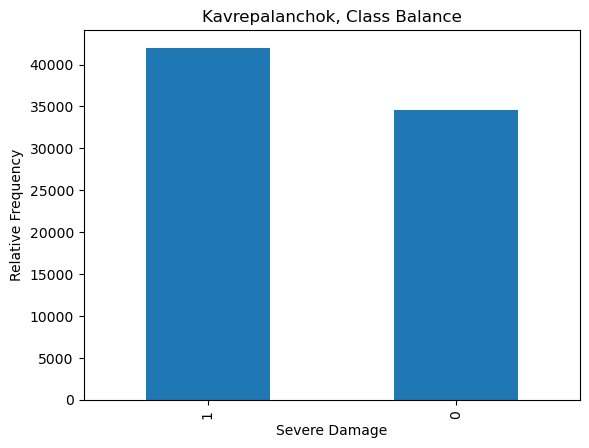

In [9]:
# Explore
# Plot of value counts of `"severe_damage"`
df['severe_damage'].value_counts().plot(kind="bar")
plt.title ("Kavrepalanchok, Class Balance")
plt.xlabel ("Severe Damage")
plt.ylabel("Relative Frequency");

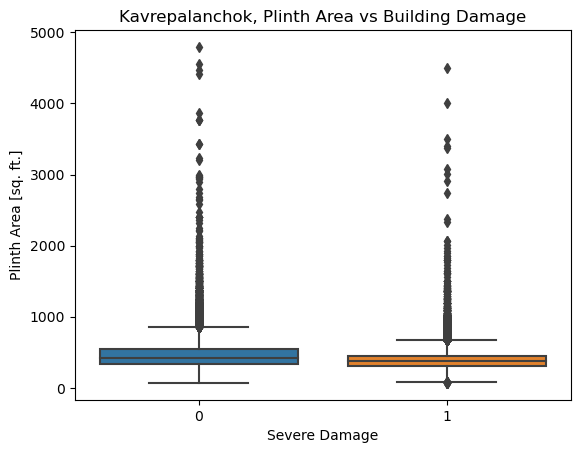

In [10]:
# boxplot shows the "plinth_area_sq_ft" distributions for 'severe_damage' values
sns.boxplot (x="severe_damage",y="plinth_area_sq_ft",data=df)
plt.title ("Kavrepalanchok, Plinth Area vs Building Damage")
plt.xlabel ("Severe Damage")
plt.ylabel("Plinth Area [sq. ft.]");

In [11]:
# Are buildings with certain roof types more likely to suffer severe damage?
roof_pivot = df.groupby("roof_type")["severe_damage"].mean().to_frame ()
roof_pivot

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842
RCC/RB/RBC,0.040715


In [12]:
# Split
X = df.drop(columns="severe_damage")
y = df["severe_damage"]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


In [13]:
# training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=.2,random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


In [14]:
# Build Model
# Baseline
# the baseline accuracy score
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


In [15]:
# Iterate
model_lr = make_pipeline (
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=3000)
)
model_lr.fit(X_train,y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [16]:
# training and validation accuracy score
lr_train_acc = model_lr.score(X_train,y_train)
lr_val_acc = model_lr.score(X_val,y_val)
print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)


Logistic Regression, Training Accuracy Score: 0.65173292392121
Logistic Regression, Validation Accuracy Score: 0.6489841249101718


In [17]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt =  make_pipeline(
    OrdinalEncoder(),DecisionTreeClassifier(max_depth=d, random_state=42)
    ) 
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train, y_train))
    validation_acc.append(model_dt.score(X_val, y_val))

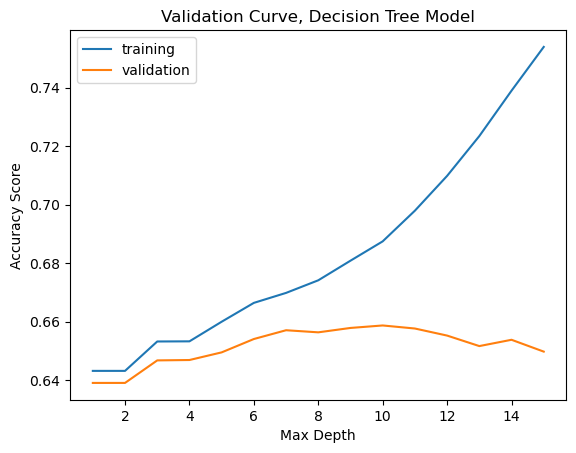

In [18]:
# plot for the validation curve
plt.plot(depth_hyperparams,training_acc,label ="training")
plt.plot(depth_hyperparams,validation_acc,label ="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title ("Validation Curve, Decision Tree Model")
plt.legend ();

In [19]:
# decision tree model
final_model_dt =  make_pipeline(
    OrdinalEncoder(),DecisionTreeClassifier(max_depth=10, random_state=42)
    ) 
final_model_dt.fit(X_train, y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
U-shape                             9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, cement mortar     3
Brick, mud mortar        4
RC, non-engineered       5
RC, engineered           6
Timber                   7
Stone, cement mortar     8
Other                    9
Bamboo                  10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [33]:
# Evaluate
query = """
    select *
    from kavrepalanchok_test_features$
    """
conn = pyodbc.connect('Driver={SQL Server};'
        'Server=DESKTOP-C6O0T9S;'
        'Database=PortfolioProject;'
        'Trusted_Connection=yes;')
X_test =pd.read_sql(query, conn, index_col="b_id")
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[:5]

C:\Users\PanDa\AppData\Local\Temp\ipykernel_5108\1194785911.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  X_test =pd.read_sql(query, conn, index_col="b_id")


array([1, 1, 0, 1, 0])

In [34]:
# Communicate Results
features = X_train.columns
importances = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp = feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.head()

plan_configuration        0.003252
position                  0.006702
roof_type                 0.013506
land_surface_condition    0.015774
ground_floor_type         0.016269
dtype: float64

Text(0.5, 1.0, 'Kavrepalanchok Decision Tree, Feature Importance')

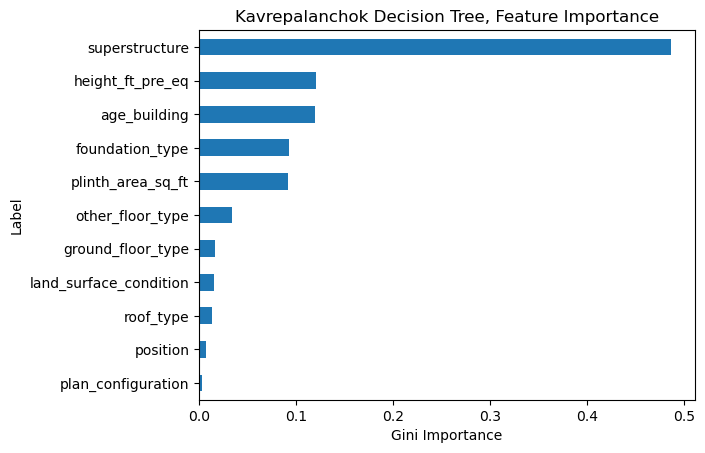

In [36]:
# horizontal bar chart of feature importances
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Label")
plt.title ("Kavrepalanchok Decision Tree, Feature Importance")